In [25]:
# ===================================================================
# IMPORTS
# ===================================================================
from functions import *


Libraries imported successfully
pymrio version: 0.5.4
Base path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit
EXIOBASE data path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Exiobase3_ixi_latest
Results will be saved to: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Results
Years for time series: 1995-2022
Loading population data from: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\exiobase3_population_2022_official.csv
Population data shape: (49, 3)
Columns: ['EXIOBASE3_Code', 'Population_2022', 'Source']

First 5 rows:
  EXIOBASE3_Code  Population_2022             Source
0             AT       9041851.00  World Bank (2022)
1             BE      11680210.00  World Bank (2022)
2             BG       6643324.00  World Bank (2022)
3             CY       1331370.00  World Bank (2022)
4             CZ      10672118.00  World Bank (2022)
Defined 20 emission categories
Defined 9 total value-added components
  - 2 tax components
 

In [12]:

# ===================================================================
# LOAD DATA
# ===================================================================

# Load EXIOBASE for single year
ixi_data = load_exiobase_year(SINGLE_YEAR)



Loading EXIOBASE data for year 2019...
✓ Year 2019 loaded successfully
  Regions: 49
  Sectors: 163


In [ ]:
# Load population
population_2022 = load_population_data()

In [27]:
# ===================================================================
# SECTOR MAPPING
# ===================================================================

# Get all sectors from EXIOBASE
all_sectors = ixi_data.get_sectors()
print(f"Total sectors in EXIOBASE: {len(all_sectors)}")

# Create DataFrame with sector mapping
df_sectors = pd.DataFrame({'sector': all_sectors})
df_sectors['category'] = df_sectors['sector'].apply(category_of)
df_sectors['colour'] = df_sectors['sector'].apply(colour_of)

print("\nSector distribution:")
print(df_sectors['category'].value_counts())

# Check for unmapped sectors
unmapped = df_sectors[df_sectors['category'] == 'other']
if len(unmapped) > 0:
    print(f"\nWarning: {len(unmapped)} unmapped sectors:")
    print(unmapped['sector'].tolist())

# Create analysis-specific sector lists
fossil_sectors = get_sectors_by_categories(["Coal", "Oil", "Gas"])
service_sectors = get_sectors_by_categories(["Services"])

print(f"\nFossil fuel sectors: {len(fossil_sectors)}")
print(f"Service sectors: {len(service_sectors)}")


Total sectors in EXIOBASE: 163

Sector distribution:
Waste & Recycling                           23
Services                                    18
Agriculture                                 17
Metals                                      15
Manufacturing (Other)                       13
Manufacturing (Food & Beverages)            12
Manufacturing (Machinery & Equipment)        8
Non-metallic Minerals                        8
Chemicals & Plastics                         7
Renewables                                   7
Electricity & Heat Infrastructure            7
Transport                                    6
Gas                                          5
Oil                                          5
Manufacturing (Textiles, Leather & Wood)     4
Construction & Trade                         3
Coal                                         3
other                                        2
Name: category, dtype: int64

['Mining of chemical and fertilizer minerals, production of salt, other

In [18]:
# ===================================================================
# CALCULATE CLEAN VA COEFFICIENTS
# ===================================================================

# All components
v_clean_all, v_raw_all = calculate_clean_va_coefficients(
    ixi_data, VALUE_ADDED_COMPONENTS
)

# Profit only
v_clean_profit, v_raw_profit = calculate_clean_va_coefficients(
    ixi_data, PROFIT_COMPONENTS
)

# Without taxes
components_no_tax = [c for c in VALUE_ADDED_COMPONENTS if c not in TAX_COMPONENTS]
v_clean_no_tax, v_raw_no_tax = calculate_clean_va_coefficients(
    ixi_data, components_no_tax
)

# ===================================================================
# RUN RESPONSIBILITY CALCULATIONS
# ===================================================================

print("\n" + "="*70)
print("CALCULATING ALL RESPONSIBILITY METHODS")
print("="*70)

# Producer responsibility
producer_emissions, missing = calculate_producer_responsibility(
    ixi_data, EMISSION_CATEGORIES
)

# Consumer responsibility
consumer_by_country, consumer_details = calculate_consumer_responsibility(
    ixi_data, producer_emissions
)

# VABR - all components
vabr_all, vabr_all_details, consumer_baseline = calculate_vabr(
    ixi_data, producer_emissions, v_clean_all
)

# VABR - profit only
vabr_profit, vabr_profit_details, _ = calculate_vabr(
    ixi_data, producer_emissions, v_clean_profit
)

# VABR - no taxes
vabr_no_tax, vabr_no_tax_details, _ = calculate_vabr(
    ixi_data, producer_emissions, v_clean_no_tax
)

# Bottom-up (producer-centric)
bottom_up_profit = calculate_producer_centric_vabr(
    ixi_data, producer_emissions, v_clean_profit, method='leontief'
)

print("\n" + "="*70)
print("ALL CALCULATIONS COMPLETE")
print("="*70)


Calculating VA coefficients using 9 components...
  Set 0 negative VA values to 0
  Capped 37 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=1.7726
  AFTER cleaning:  Min=0.0000, Max=1.0000
Calculating VA coefficients using 4 components...
  Set 0 negative VA values to 0
  Capped 15 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=36.3956
  AFTER cleaning:  Min=0.0000, Max=1.0000
Calculating VA coefficients using 7 components...
  Set 0 negative VA values to 0
  Capped 59 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=37.3111
  AFTER cleaning:  Min=0.0000, Max=1.0000

CALCULATING ALL RESPONSIBILITY METHODS
Total producer emissions: 44.715 Gt CO2-eq
Total consumer emissions: 44.712 Gt CO2-eq

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

=== VABR CALCULATION

ANALYSIS

In [31]:
print("\n" + "="*70)
print(f"ANALYSIS 1: Top Emitters Comparison ({SINGLE_YEAR})")
print("="*70)

# Aggregate producer emissions by country
producer_by_country = {}
for region in ixi_data.get_regions():
    mask = ixi_data.x.index.get_level_values(0) == region
    region_indices = np.where(mask)[0]
    producer_by_country[region] = producer_emissions[region_indices].sum()

producer_totals = pd.Series(producer_by_country)

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Producer': producer_totals / 1e9,
    'Consumer': consumer_by_country / 1e9,
    'VABR (All)': vabr_all / 1e9,
    'VABR (Profit)': vabr_profit / 1e9,
    'Bottom-Up': bottom_up_profit / 1e9
})

# Select top 7 countries (by sum across all methods)
country_totals = comparison.sum(axis=1)
top7_countries = country_totals.nlargest(7).index.tolist()

print(f"\nTop 7 countries: {top7_countries}")
print("\nComparison (Gt CO2-eq):")
print(comparison.loc[top7_countries].round(2))


ANALYSIS 1: Top Emitters Comparison (2019)

Top 7 countries: ['CN', 'US', 'WA', 'IN', 'WM', 'WF', 'RU']

Comparison (Gt CO2-eq):
    Producer  Consumer  VABR (All)  VABR (Profit)  Bottom-Up
CN     12.96     11.82       11.46          11.04       5.37
US      5.10      6.21        6.52           6.59       2.35
WA      3.52      3.70        3.07           2.37       2.17
IN      3.45      3.17        2.90           2.96       1.90
WM      3.06      2.54        2.45           2.77       2.06
WF      2.24      2.22        1.88           1.88       1.50
RU      2.04      1.55        1.52           1.61       1.33


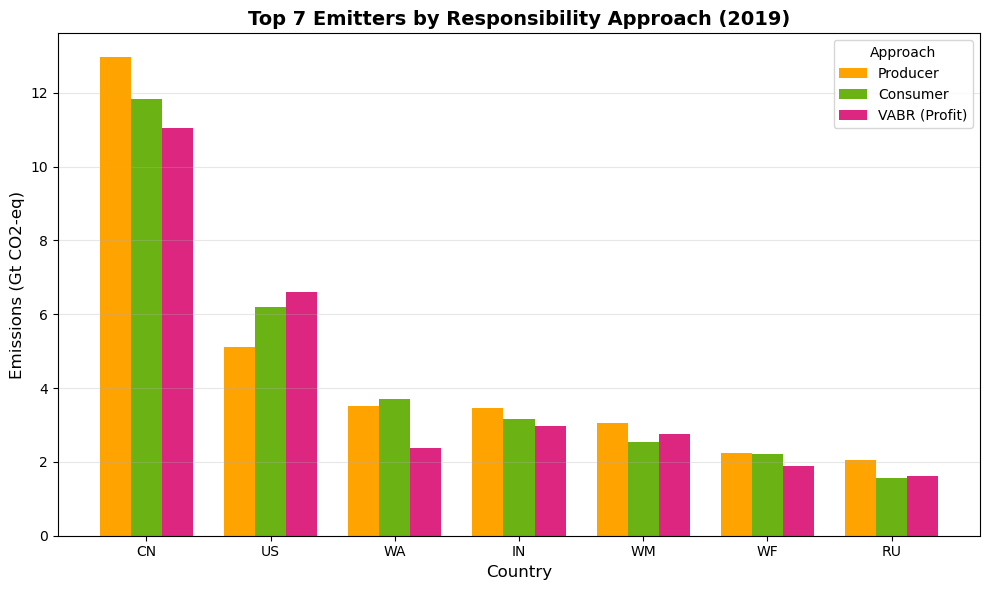

In [32]:
# ===================================================================
# GROUPED BAR PLOT
# ===================================================================

# Select which methods to plot
plot_data = comparison.loc[top7_countries, ['Producer', 'Consumer', 'VABR (Profit)']]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(top7_countries))
width = 0.25
colors = ['#ffa300', '#6bb314', '#dc267f']

for i, (method, color) in enumerate(zip(plot_data.columns, colors)):
    ax.bar(
        x + (i - 1) * width,
        plot_data[method].values,
        width,
        label=method,
        color=color
    )

ax.set_title(f'Top 7 Emitters by Responsibility Approach ({SINGLE_YEAR})', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('Emissions (Gt CO2-eq)', fontsize=12)
ax.set_xlabel('Country', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(top7_countries)
ax.legend(title="Approach", fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



ANALYSIS 2: Per Capita Emissions (2019)

Countries with population data: 49

TOP 10 PER CAPITA EMITTERS (tonnes CO2-eq/person)

PRODUCER:
 1. AU:  20.98 tonnes/person
 2. CA:  17.18 tonnes/person
 3. US:  15.30 tonnes/person
 4. NO:  14.43 tonnes/person
 5. RU:  14.17 tonnes/person
 6. GR:  13.03 tonnes/person
 7. TW:  12.87 tonnes/person
 8. DK:  12.77 tonnes/person
 9. KR:  12.67 tonnes/person
10. FI:  12.15 tonnes/person

CONSUMER:
 1. LU:  22.65 tonnes/person
 2. CH:  19.15 tonnes/person
 3. IE:  18.76 tonnes/person
 4. US:  18.62 tonnes/person
 5. AU:  17.79 tonnes/person
 6. KR:  16.08 tonnes/person
 7. NO:  14.59 tonnes/person
 8. CA:  14.02 tonnes/person
 9. NL:  13.72 tonnes/person
10. BE:  12.90 tonnes/person

VABR (ALL):
 1. LU:  36.19 tonnes/person
 2. IE:  26.70 tonnes/person
 3. CH:  26.30 tonnes/person
 4. AU:  21.64 tonnes/person
 5. US:  19.57 tonnes/person
 6. NO:  18.87 tonnes/person
 7. DK:  17.36 tonnes/person
 8. KR:  17.30 tonnes/person
 9. NL:  17.15 tonnes/per

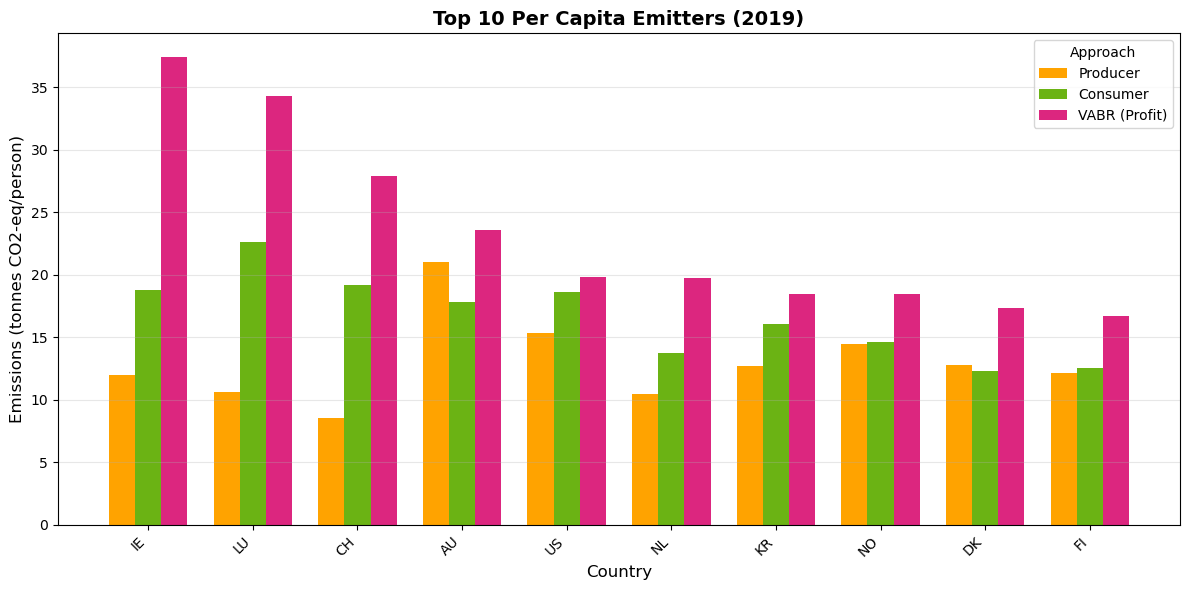


✓ Per capita analysis complete


In [33]:
# ===================================================================
# ANALYSIS 2: PER CAPITA EMISSIONS
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 2: Per Capita Emissions ({SINGLE_YEAR})")
print("="*70)

# Create per capita DataFrame
per_capita = pd.DataFrame({
    'Producer': producer_totals / population_2022,  # tonnes per person
    'Consumer': consumer_by_country / population_2022,
    'VABR (All)': vabr_all / population_2022,
    'VABR (Profit)': vabr_profit / population_2022,
    'Bottom-Up': bottom_up_profit / population_2022
})

# Remove countries with missing population data
per_capita = per_capita.dropna()

print(f"\nCountries with population data: {len(per_capita)}")

# Display top 10 for each approach
print("\n" + "="*70)
print("TOP 10 PER CAPITA EMITTERS (tonnes CO2-eq/person)")
print("="*70)

for method in per_capita.columns:
    print(f"\n{method.upper()}:")
    top10 = per_capita[method].nlargest(10)
    for i, (country, emissions) in enumerate(top10.items(), 1):
        print(f"{i:2d}. {country}: {emissions:6.2f} tonnes/person")

# ===================================================================
# PER CAPITA BAR PLOT
# ===================================================================

# Select top 10 countries by VABR (Profit) per capita
top10_per_capita = per_capita.nlargest(10, 'VABR (Profit)').index.tolist()

# Plot data
plot_data = per_capita.loc[top10_per_capita, ['Producer', 'Consumer', 'VABR (Profit)']]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(top10_per_capita))
width = 0.25
colors = ['#ffa300', '#6bb314', '#dc267f']

for i, (method, color) in enumerate(zip(plot_data.columns, colors)):
    ax.bar(
        x + (i - 1) * width,
        plot_data[method].values,
        width,
        label=method,
        color=color
    )

ax.set_title(f'Top 10 Per Capita Emitters ({SINGLE_YEAR})', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('Emissions (tonnes CO2-eq/person)', fontsize=12)
ax.set_xlabel('Country', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(top10_per_capita, rotation=45, ha='right')
ax.legend(title="Approach", fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Per capita analysis complete")